<a href="https://colab.research.google.com/github/rpedram/data-science/blob/main/Final_TCS_Moving_Average_Crossover_Backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Modify the provided Python code for a moving average crossover trading strategy backtest to include interactive pickers for the `short_window`, `long_window`, `initial_capital`, `start_date`, and `end_date` variables using `ipywidgets`. Update the code to use the values selected by these pickers and then run the backtest.

## Generate pickers

### Subtask:
Create interactive pickers for `short_window`, `long_window`, `initial_capital`, `start_date`, and `end_date` using `ipywidgets`.


**Reasoning**:
Create and display the interactive widgets for the backtesting parameters as requested by the subtask.



In [50]:
import ipywidgets as widgets
from IPython.display import display
import datetime

# Create IntSlider widgets for short_window and long_window
short_window_slider = widgets.IntSlider(
    value=50,
    min=10,
    max=100,
    step=5,
    description='Short MA Window:',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

long_window_slider = widgets.IntSlider(
    value=200,
    min=100,
    max=300,
    step=10,
    description='Long MA Window:',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# Create FloatSlider widget for initial_capital
initial_capital_slider = widgets.FloatSlider(
    value=1000000.0,
    min=100000.0,
    max=10000000.0,
    step=100000.0,
    description='Initial Capital:',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

# Create DatePicker widgets for start_date and end_date
start_date_picker = widgets.DatePicker(
    description='Start Date:',
    disabled=False,
    value=datetime.date(2015, 1, 1)
)

end_date_picker = widgets.DatePicker(
    description='End Date:',
    disabled=False,
    value=datetime.date(2024, 8, 1)
)

# Display the widgets
print("Please select the backtesting parameters:")
display(short_window_slider)
display(long_window_slider)
display(initial_capital_slider)
display(start_date_picker)
display(end_date_picker)

Please select the backtesting parameters:


IntSlider(value=50, continuous_update=False, description='Short MA Window:', min=10, step=5)

IntSlider(value=200, continuous_update=False, description='Long MA Window:', max=300, min=100, step=10)

FloatSlider(value=1000000.0, continuous_update=False, description='Initial Capital:', max=10000000.0, min=1000…

DatePicker(value=datetime.date(2015, 1, 1), description='Start Date:')

DatePicker(value=datetime.date(2024, 8, 1), description='End Date:')

## Modify code to use picker values

### Subtask:
Update the existing backtesting code to use the values selected by the pickers.


**Reasoning**:
Update the existing backtesting code to use the values from the ipywidgets pickers.



[*********************100%***********************]  1 of 1 completed


/tmp/ipython-input-4068443085.py:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Price': portfolio['price'][i],
/tmp/ipython-input-4068443085.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{data.index[i].date()}: BUY Signal @ {portfolio['price'][i]:.2f} for {shares_to_buy} shares")


Data downloaded successfully.
Calculating moving averages...
Trading signals generated.
Running backtest simulation...
2020-08-19: BUY Signal @ 2098.34 for 190.0 shares


/tmp/ipython-input-4068443085.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Price': portfolio['price'][i],
/tmp/ipython-input-4068443085.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{data.index[i].date()}: SELL Signal @ {portfolio['price'][i]:.2f} for {shares_to_sell} shares")
/tmp/ipython-input-4068443085.py:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Price': portfolio['price'][i],
/tmp/ipython-inp

2022-05-06: SELL Signal @ 3246.23 for 190 shares
2023-01-04: BUY Signal @ 3172.32 for 194.0 shares


/tmp/ipython-input-4068443085.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Price': portfolio['price'][i],
/tmp/ipython-input-4068443085.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{data.index[i].date()}: SELL Signal @ {portfolio['price'][i]:.2f} for {shares_to_sell} shares")
/tmp/ipython-input-4068443085.py:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Price': portfolio['price'][i],
/tmp/ipython-inp

2023-05-05: SELL Signal @ 3099.32 for 194 shares
2023-07-06: BUY Signal @ 3211.48 for 188.0 shares


/tmp/ipython-input-4068443085.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Price': portfolio['price'][i],
/tmp/ipython-input-4068443085.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{data.index[i].date()}: SELL Signal @ {portfolio['price'][i]:.2f} for {shares_to_sell} shares")


2025-02-19: SELL Signal @ 3738.08 for 188 shares
Backtest simulation complete.

--- Trade Log ---
         Date Action        Price  Shares  Portfolio Value
0  2020-08-19    BUY  2098.343994   190.0    400000.000000
1  2022-05-06   SELL  3246.231934   190.0    618098.708496
2  2023-01-04    BUY  3172.320068   194.0    618098.708496
3  2023-05-05   SELL  3099.322998   194.0    603937.276855
4  2023-07-06    BUY  3211.480957   188.0    603937.276855
5  2025-02-19   SELL  3738.076172   188.0    702937.177246

--- Backtest Performance ---
Initial Capital:          400,000.00 INR
Final Portfolio Value:    702,937.18 INR
Strategy Total Return:    75.73%
Buy and Hold Total Return:76.65%
Annualized IRR:           12.26%

Generating plot...


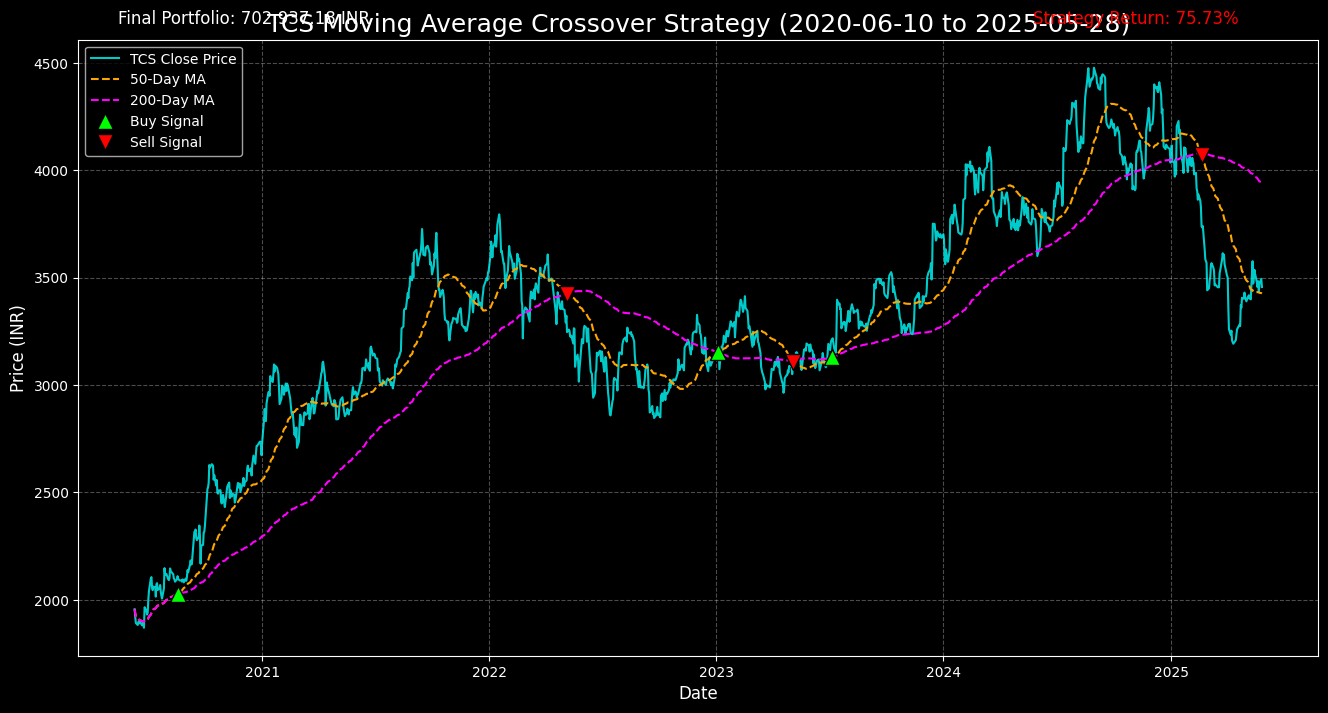

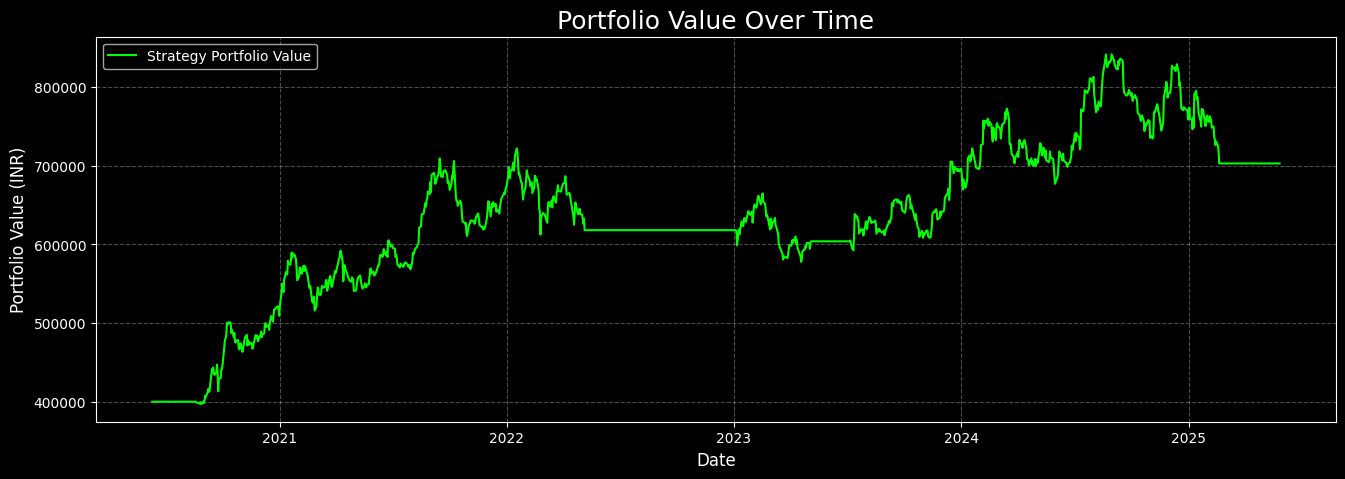

In [59]:
# @title Choose Stock {"run":"auto","vertical-output":true}
ticker = "TCS.NS" # @param ["INFY.NS","TCS.NS","CIPLA.NS","HDFCBANK.NS","ITC.NS","M&M.NS","NESTLEIND.NS","NTPC.NS",""]
# Step 1: Install and import necessary libraries
# yfinance for downloading stock data and matplotlib for plotting.
# pandas is used for data manipulation and analysis.
# numpy_financial is needed for IRR calculation.
#!pip install yfinance pandas matplotlib numpy_financial
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy_financial as npf

'''
# --- Backtesting Parameters ---
# Define the stock ticker for Tata Consultancy Services on the National Stock Exchange (NSE)
ticker = 'TCS.NS'
# Define the start and end dates for our backtest
start_date = '2015-01-01'
end_date = '2024-08-01'
# Define the moving average windows
short_window = 50
long_window = 200
# Define the initial capital for our simulation
initial_capital = 1000000.0  # 10 Lakh INR

'''

#  Step 1Backtesting Parameters (Using values from pickers) ---
# Define the stock ticker for Tata Consultancy Services on the National Stock Exchange (NSE)
#ticker = 'TCS.NS'
# Define the start and end dates for our backtest using picker values
start_date = start_date_picker.value.strftime('%Y-%m-%d')
end_date = end_date_picker.value.strftime('%Y-%m-%d')
# Define the moving average windows using slider values
short_window = short_window_slider.value
long_window = long_window_slider.value
# Define the initial capital for our simulation using slider value
initial_capital = initial_capital_slider.value

# Step 2: Download the historical stock data
print(f"Downloading historical data for {ticker} from {start_date} to {end_date}...")
try:
    # Set auto_adjust=True to get adjusted close prices, which account for splits and dividends
    data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
    if data.empty:
        raise ValueError("No data downloaded. Check the ticker symbol or date range.")
    print("Data downloaded successfully.")
except Exception as e:
    print(f"Error downloading data: {e}")
    # Exit if data download fails
    exit()

# Step 3: Calculate the Moving Averages
print("Calculating moving averages...")
data['short_ma'] = data['Close'].rolling(window=short_window, min_periods=1).mean()
data['long_ma'] = data['Close'].rolling(window=long_window, min_periods=1).mean()

# Step 4: Generate Trading Signals
# A signal is generated when the short MA crosses the long MA.
# We create a 'signal' column: 1.0 for a buy signal (golden cross), 0.0 for no action.
data['signal'] = 0.0
# Use .loc to avoid the SettingWithCopyWarning
data.loc[data.index[short_window:], 'signal'] = np.where(
    data['short_ma'][short_window:] > data['long_ma'][short_window:], 1.0, 0.0
)

# We then find the exact points where the trade should happen.
# 'positions' will be 1 for a buy, -1 for a sell.
data['positions'] = data['signal'].diff()
print("Trading signals generated.")

# --- Step 5: Run the Hypothetical Backtest (Corrected Logic) ---
print("Running backtest simulation...")
# Create a portfolio DataFrame to track our shares, cash, and total value
portfolio = pd.DataFrame(index=data.index).fillna(0.0)
portfolio['price'] = data['Close']
portfolio['shares'] = 0  # We will track the number of shares
portfolio['cash'] = initial_capital
portfolio['total'] = initial_capital
trade_log = [] # To store details of each trade

# Loop through the data to simulate trades
for i in range(1, len(portfolio)):
    # Carry forward the previous day's portfolio values
    portfolio.loc[portfolio.index[i], 'shares'] = portfolio.loc[portfolio.index[i-1], 'shares']
    portfolio.loc[portfolio.index[i], 'cash'] = portfolio.loc[portfolio.index[i-1], 'cash']

    # Check for a BUY signal (positions == 1.0)
    if data.loc[data.index[i], 'positions'].item() == 1.0:
        # Check if we are not already in the market
        if portfolio.loc[portfolio.index[i-1], 'shares'] == 0:
            # Calculate how many shares we can buy
            shares_to_buy = portfolio.loc[portfolio.index[i], 'cash'] // portfolio.loc[portfolio.index[i], 'price']
            # Update shares and cash
            portfolio.loc[portfolio.index[i], 'shares'] += shares_to_buy
            portfolio.loc[portfolio.index[i], 'cash'] -= shares_to_buy * portfolio.loc[portfolio.index[i], 'price']

            # Log the trade
            trade_log.append({
                'Date': data.index[i].date(),
                'Action': 'BUY',
                'Price': portfolio['price'][i],
                'Shares': shares_to_buy,
                'Portfolio Value': portfolio.loc[portfolio.index[i-1], 'total']
            })
            print(f"{data.index[i].date()}: BUY Signal @ {portfolio['price'][i]:.2f} for {shares_to_buy} shares")

    # Check for a SELL signal (positions == -1.0)
    elif data.loc[data.index[i], 'positions'].item() == -1.0:
        # Check if we actually have shares to sell
        if portfolio.loc[portfolio.index[i-1], 'shares'] > 0:
            shares_to_sell = portfolio.loc[portfolio.index[i-1], 'shares']
            # Sell all shares
            portfolio.loc[portfolio.index[i], 'cash'] += shares_to_sell * portfolio.loc[portfolio.index[i], 'price']
            portfolio.loc[portfolio.index[i], 'shares'] = 0

            # Log the trade
            trade_log.append({
                'Date': data.index[i].date(),
                'Action': 'SELL',
                'Price': portfolio['price'][i],
                'Shares': shares_to_sell,
                'Portfolio Value': portfolio.loc[portfolio.index[i-1], 'shares'] * portfolio.loc[portfolio.index[i], 'price'] + portfolio.loc[portfolio.index[i-1], 'cash']
            })
            print(f"{data.index[i].date()}: SELL Signal @ {portfolio['price'][i]:.2f} for {shares_to_sell} shares")

    # *** IMPORTANT: Update the total portfolio value daily based on current price ***
    current_holdings_value = portfolio.loc[portfolio.index[i], 'shares'] * portfolio.loc[portfolio.index[i], 'price']
    portfolio.loc[portfolio.index[i], 'total'] = portfolio.loc[portfolio.index[i], 'cash'] + current_holdings_value

print("Backtest simulation complete.")

# --- Step 6: Display Trade Log ---
print("\n--- Trade Log ---")
if not trade_log:
    print("No trades were made during the backtest period.")
else:
    trade_df = pd.DataFrame(trade_log)
    print(trade_df.to_string())


# --- Step 7: Calculate and Display Performance Metrics ---
print("\n--- Backtest Performance ---")
final_portfolio_value = portfolio['total'].iloc[-1]
strategy_return = ((final_portfolio_value - initial_capital) / initial_capital) * 100

# Compare with a simple "Buy and Hold" strategy
buy_and_hold_return = ((data['Close'].iloc[-1] - data['Close'].iloc[0]) / data['Close'].iloc[0]) * 100

# Calculate IRR
# Create a series of cash flows: initial capital is an outflow, final value is an inflow
cash_flows = [-initial_capital] + [0] * (len(portfolio) - 1)
cash_flows[-1] = final_portfolio_value
# Create a date range for the cash flows
dates = pd.to_datetime(portfolio.index)
# Calculate daily returns to then annualize IRR
daily_returns = portfolio['total'].pct_change().dropna()
# Calculate annualized IRR
if len(daily_returns) > 0:
    # geometric mean for annualization
    mean_daily_return = (1 + daily_returns).prod()**(1/len(daily_returns)) - 1
    annual_irr = (1 + mean_daily_return)**252 - 1 # Assuming 252 trading days in a year
else:
    annual_irr = 0


print(f"Initial Capital:          {initial_capital:,.2f} INR")
print(f"Final Portfolio Value:    {final_portfolio_value:,.2f} INR")
print(f"Strategy Total Return:    {strategy_return:.2f}%")
print(f"Buy and Hold Total Return:{buy_and_hold_return.item():.2f}%")
print(f"Annualized IRR:           {annual_irr:.2%}")


# --- Step 8: Visualize the Results ---
print("\nGenerating plot...")
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(16, 8))

# Plot price and moving averages
ax.plot(data['Close'], label='TCS Close Price', color='cyan', alpha=0.8, linewidth=1.5)
ax.plot(data['short_ma'], label=f'{short_window}-Day MA', color='orange', linestyle='--', linewidth=1.5)
ax.plot(data['long_ma'], label=f'{long_window}-Day MA', color='magenta', linestyle='--', linewidth=1.5)

# Plot Buy signals
buy_signals = data[data['positions'] == 1.0]
ax.plot(buy_signals.index, data.loc[buy_signals.index]['short_ma'], '^', markersize=12, color='lime', label='Buy Signal', markeredgecolor='black')

# Plot Sell signals
sell_signals = data[data['positions'] == -1.0]
ax.plot(sell_signals.index, data.loc[sell_signals.index]['short_ma'], 'v', markersize=12, color='red', label='Sell Signal', markeredgecolor='black')

# Formatting the plot
ax.set_title(f'TCS Moving Average Crossover Strategy ({start_date} to {end_date})', fontsize=18)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (INR)', fontsize=12)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, linestyle='--', alpha=0.3)
plt.figtext(0.15, 0.90, f"Final Portfolio: {final_portfolio_value:,.2f} INR", ha="left", fontsize=12, color="white")
plt.figtext(0.85, 0.90, f"Strategy Return: {strategy_return:.2f}%", ha="right", fontsize=12, color="lime" if strategy_return > buy_and_hold_return.item() else "red")


plt.show()

# Plotting the portfolio value over time
fig2, ax2 = plt.subplots(figsize=(16, 5))
ax2.plot(portfolio['total'], label='Strategy Portfolio Value', color='lime')
ax2.set_title('Portfolio Value Over Time', fontsize=18)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Portfolio Value (INR)', fontsize=12)
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.3)
plt.show()

In [54]:
# Calculate profit/loss for each trade
trade_df['Trade_Value'] = trade_df['Price'] * trade_df['Shares']

# Determine profit or loss for each trade
# Assuming a simple model where profit/loss is the difference in value between sell and buy
# We need to pair up buy and sell trades. Assuming consecutive buy/sell pairs for simplicity here.
# A more sophisticated approach would track open positions.

profitable_trades = 0
loss_making_trades = 0
open_buy_price = None
open_buy_shares = 0

for index, row in trade_df.iterrows():
    if row['Action'] == 'BUY':
        open_buy_price = row['Price']
        open_buy_shares = row['Shares']
    elif row['Action'] == 'SELL' and open_buy_price is not None:
        sell_price = row['Price']
        # Calculate profit/loss for the paired buy and sell
        profit_loss = (sell_price - open_buy_price) * open_buy_shares

        if profit_loss > 0:
            profitable_trades += 1
        elif profit_loss < 0:
            loss_making_trades += 1

        # Reset open position
        open_buy_price = None
        open_buy_shares = 0

print(f"Number of profitable trades: {profitable_trades}")
print(f"Number of loss-making trades: {loss_making_trades}")

Number of profitable trades: 3
Number of loss-making trades: 5
